# 4. Modelado del conjunto de datos
A lo largo de este notebook se cubre parte de la cuarta fase de la metodología CRIPS-DM, en este caso el modelado del conjunto de datos. En este notebook se emplea para el mismo un ensemble conformado por SAM + RetineNet

1. **Comprensión del Negocio (Business Understanding)**
   - Consistente en el entendimiento del objetivo del proyecto.

2. **Comprensión de los Datos (Data Understanding)**
   - Relacionada con la carga y primera evaluación del conjunto de datos. Se divide a su vez en :


3. **Preparación de los Datos (Data Preparation)** 
   - Consistente en la limpieza, preparación y extracción de características de los datos.

4. <span style="color:#66FF99;">**Modelado (Modeling)**  </span> 
   - Relacionada con la elección del modelo de machine learning y el ajuste hiperparamétrico. En este caso, se probara con una arquitectura ensemble opuesta a las testeadas anteriormente, donde la segmentación se realiza en primera instancia y posteriormente se infere la clase a la que pertenece cada una de las máscaras generadas. Los modelos usados para ello serán CLIP para la clasificación de la máscara y SAM para la generación de la misma.

5. **Evaluación (Evaluation)**  
   - Evaluación de los resultados obtenidos por el modelo.

6. **Implementación (Deployment)**  
   - Integración del modelo de forma que sea accesible para su uso.


## Modelado mediante SAM y CLIP

La arquitectura del modelo queda dividida en dos fases, una primera compuesta por Segment Anything Model al que se le ingesta como unico input la imagen a segmentar, que generará el conjunto de segmentaciones encontradas, y un segundo bloque conformado por CLIP, que posee una representación común para imágenes y para texto, lo que permite asignar cada una de las máscaras con una etiqueta o bien clasificarla como fondo si no supera un umbral de similitud.
Una representación gráfica de esta arquitectura es la siguiente:

## 1. Generación de máscaras


Se generan cada una de las máscaras presentes mediante el metodo Segment everything de SAM





In [1]:
from pathlib import Path
from utils import  load_yaml_file, download_zip
import os
from transformers import CLIPProcessor, CLIPModel

import matplotlib.pyplot as plt
import cv2
from pycocotools.coco import COCO
import numpy as np
import random

from pathlib import Path
from utils import  load_yaml_file, download_zip
import os

from clip import load, tokenize
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

import time

import torch
import torchvision.transforms as transforms
from PIL import Image

from segment_anything import SamAutomaticMaskGenerator

import clip
import pandas as pd
from sklearn.metrics import average_precision_score

from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches


In [2]:
yaml = load_yaml_file()


In [3]:
objetives = yaml["objetive_classes"]


In [4]:
DIR_TRAIN_ANNOTATIONS = yaml["dirs"]["anotaciones"]["train"]
DIR_TRAIN_IMGS = yaml["dirs"]["imagenes"]["train"]
DIR_TRAIN_IMGS = os.path.join(os.getcwd(),"..", DIR_TRAIN_IMGS)

coco=COCO(os.path.join(os.getcwd(),"..", DIR_TRAIN_ANNOTATIONS))

loading annotations into memory...
Done (t=23.80s)
creating index...
index created!


Se buscan obtener los ids de las categorias a capturar, almacenadas en categories:

In [5]:
categories = coco.loadCats(coco.getCatIds())
category_info_id = {cat['id']: cat['name'] for cat in categories}
category_info_name = { cat['name']:cat['id'] for cat in categories}

id_objetives = [category_info_name[name] for name in objetives]
category_info_objetive = {i:category_info_id[i] for i in id_objetives}
category_info_objetive[0] = "background"
categories_names_by_index = { i: category_info_objetive[id_cat] for i , id_cat in enumerate(sorted(category_info_objetive.keys()))}


dict_class_index = {key:i for i , key in enumerate(sorted(category_info_objetive.keys()))}
mapper_indexModel_index_result = {value:i for i, value in enumerate(sorted(category_info_objetive.keys()))}

Ahora se obtienen el subconjunto de ids de imágenes que contienen al menos una de las categorías:

In [6]:

img_ids = set(coco.getImgIds(catIds=id_objetives[0]))

for cat in id_objetives[1:]:
    img_ids |= set(coco.getImgIds(catIds=cat))

img_ids = list(img_ids)


print(f"Las imagenes con las clases coindicentes son  {len(img_ids)}")

Las imagenes con las clases coindicentes son  79542


Del conjunto que contienen al menos una clase, definimos un umbral minimo y vemos si la suma de pixeles que supone la totalidad de las máscaras es o no significativa para nuestro conjunto de entrenamiento

In [7]:
THRESHOLD = 10000 

images_id_final = []

for img_id in img_ids:
    ann_ids = coco.getAnnIds(imgIds=img_id, catIds=id_objetives)

    total_mask = 0 

    for ann in ann_ids:
        ann = coco.loadAnns(ann)[0]
        total_mask += np.sum(coco.annToMask(ann))

        if(total_mask > THRESHOLD):
            break
    if(total_mask > THRESHOLD):
        images_id_final.append(img_id)


img_ids = images_id_final

In [8]:
def get_data_id_image(id_image, coco):

    img_info = coco.loadImgs(id_image)[0]
    height, width = img_info['height'], img_info['width']
    img_path = f"{DIR_TRAIN_IMGS}/{img_info['file_name']}"

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ann_ids = coco.getAnnIds(imgIds=id_image)
    anns = coco.loadAnns(ann_ids)
    mask = np.zeros((height, width), dtype=np.uint8)

    for ann in anns:
        category_id = ann['category_id']

        if(category_id in category_info_objetive.keys()):
            binary_mask = coco.annToMask(ann)
            mask[binary_mask == 1] = category_id

    return image, mask

### MODELO SAM

In [9]:
sam_checkpoint = r"C:\Users\ruben\Desktop\code_tfm\models\SAM\sam_vit_b_01ec64.pth"
model_type = "vit_b"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device= "cpu" )

sam_model = SamPredictor(sam)

In [10]:
CONS_THRESHOLD_SAM = 0.4

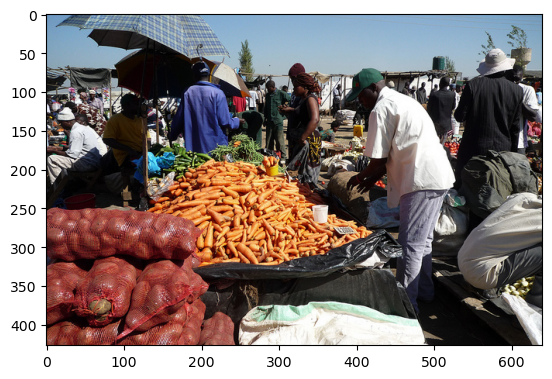

In [11]:
img, mask = get_data_id_image(img_ids[0], coco)

plt.imshow(img)

In [12]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [13]:
DEVICE ="cpu"

clip_model, preprocess = clip.load("ViT-B/32", device=DEVICE)


In [14]:
result = mask_generator.generate(img)


In [15]:
#objetives = ["a photo of a " + obj + " surrounded by dark" for obj in classes] + ["a photo of a something surrounded by dark" ]
text_prompts = ["a photo of a " + obj + " surrounded by dark" for obj in yaml["objetive_classes"]] +  ["a photo of a something surrounded by dark" , "a photo of a background surrounded by dark", "A clear blue sky above the horizon, with silhouettes of buildings and people below"]
text_tokens = clip.tokenize(text_prompts).to(DEVICE)

target_names = yaml["objetive_classes"] + ["something"] + ["background"] + ["blue sky"]

In [35]:
def prepare_clip_input_from_mask(img, mask, preprocess):
    coords = np.argwhere(mask)
    if coords.size == 0:
        return None

    y0, x0 = coords.min(axis=0)
    y1, x1 = coords.max(axis=0) + 1

    cropped_img = img[y0:y1, x0:x1]
    cropped_mask = mask[y0:y1, x0:x1]

    cropped_img = np.copy(cropped_img)
    cropped_img[~cropped_mask] = 0

    pil_image = Image.fromarray(cropped_img)

    clip_input = preprocess(pil_image).unsqueeze(0).to(DEVICE)
    return clip_input, pil_image


In [ ]:
for i, mask_dict in enumerate(result):
    mask = mask_dict["segmentation"]  # 2D bool or int array
    clip_input, cropped_pil = prepare_clip_input_from_mask(img, mask, preprocess)

    if clip_input is None:
        print(f"Segment {i}: Empty mask — skipped.")
        continue

    # Encode image and text
    with torch.no_grad():
        image_features = clip_model.encode_image(clip_input)
        text_features = clip_model.encode_text(text_tokens)

        # Normalize
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        # Cosine similarity
        similarity = (image_features @ text_features.T).squeeze(0)
        best_idx = similarity.argmax().item()
        best_label = text_prompts[best_idx]
        score = similarity[best_idx].item()

        # Visualization
        print(f"Máscara {i+1} classified as: {best_label} (score: {score:.4f})")

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

        # Cropped masked region
        ax1.imshow(cropped_pil)
        ax1.set_title(f"Máscara {i+1}")
        ax1.axis("off")

        # Similarity bar plot
        top5_scores, top5_indices = similarity.topk(3)
        top5_scores[0] += 0.3
        top5_labels = [target_names[idx] for idx in top5_indices]

        # Plot top 5 similarities
        ax2.bar(range(3), top5_scores.cpu().numpy(), tick_label=top5_labels)
        ax2.set_ylim(0, 1)
        ax2.set_title("Predicciones CLIP")
        ax2.set_ylabel("Similitud coseno")

        plt.tight_layout()
        plt.show()

In [17]:
def generate_inference_model_clip_sam(img):
    result_sam = mask_generator.generate(img)
    result = np.zeros((img.shape[0], img.shape[1]))


    for i, mask_dict in enumerate(result_sam):
        mask = mask_dict["segmentation"]  
        clip_input, cropped_pil = prepare_clip_input_from_mask(img, mask, preprocess)

        if clip_input is None:
            continue

        # Encode image and text
        with torch.no_grad():
            image_features = clip_model.encode_image(clip_input)
            text_features = clip_model.encode_text(text_tokens)

            # Normalize
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)

            # Cosine similarity
            similarity = (image_features @ text_features.T).squeeze(0)
            best_idx = similarity.argmax().item()

            if(best_idx<10):
                result[mask] = best_idx + 1

    return result

In [18]:
def preprocess_dataset_mask(mask,mapper_indexModel_index_result, categories_names_by_index):

    mask_proprocessed = np.vectorize(lambda x: mapper_indexModel_index_result.get(x, x))(mask)
    one_hot_scores = np.zeros((len(categories_names_by_index), mask.shape[0], mask.shape[1]))

    for clase in sorted(categories_names_by_index.keys()):

        one_hot_scores[clase, :, :] = np.where(mask_proprocessed == clase,1 , 0)

    one_hot_scores[0, :, :] = 1 - one_hot_scores[1:, :, :].sum(axis=0)

    return one_hot_scores
    
mask_preprocessed = preprocess_dataset_mask(mask,mapper_indexModel_index_result, categories_names_by_index)


In [19]:
def preprocess_model_output(mask):
    mask = mask.astype(int)
    one_hot = np.eye(11)[mask]
    one_hot = one_hot.transpose(2, 0, 1)
    return one_hot

In [20]:
img , mask = get_data_id_image(img_ids[0], coco)

In [21]:
result_mask = generate_inference_model_clip_sam(img)

In [22]:
def plot_image_and_mask_and_gt(image, mask, gt):
    class_id_to_name = {i:category_info_objetive[key] for i, key in enumerate(sorted(category_info_objetive.keys()))}

    #mask = np.argmax(mask, axis=2)
    class_ids = sorted([cid for cid in np.unique(list(np.unique(mask))+ list(np.unique(gt)))])

    # Uso de templates de colores predefinidas en matplot para que exista mas contraste entre clases de ids adyacentes, usando tab10
    colors = plt.cm.get_cmap('tab10',len(class_id_to_name))

    fig, ax = plt.subplots(1, 3, figsize=(12, 6))
    ax[0].imshow(image)
    ax[0].set_title("Imagen")
    ax[0].axis("off")

    # Se incializa la mascara como todo fondo, y se itera añadiendo
    mask_colored = np.zeros((mask.shape[0],mask.shape[1],3),dtype=np.uint8)
    for i,cid in enumerate(class_ids):
        mask_colored[mask==cid] = (np.array(colors(i)[:3])*255).astype(np.uint8)

    # print(mask_colored)
    ax[1].imshow(mask_colored)
    ax[1].set_title("Predicción SAM + CLIP")
    ax[1].axis("off")

    # generación de la leyenda
    patches = [mpatches.Patch(color=colors(i), label=class_id_to_name[cid])
               for i, cid in enumerate(class_ids)]

    mask_gt_colored = np.zeros((gt.shape[0],gt.shape[1],3),dtype=np.uint8)
    for i,cid in enumerate(class_ids):
        mask_gt_colored[gt==cid] = (np.array(colors(i)[:3])*255).astype(np.uint8)

    ax[2].imshow(mask_gt_colored)
    ax[2].set_title("Ground truth")
    ax[2].axis("off")

    # generación de la leyenda
    patches = [mpatches.Patch(color=colors(i), label=class_id_to_name[cid])
               for i, cid in enumerate(class_ids)]
    ax[2].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()


In [23]:
proprocessed_mask = preprocess_model_output(result_mask)

C:\Users\ruben\AppData\Local\Temp\ipykernel_19840\777447882.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10',len(class_id_to_name))


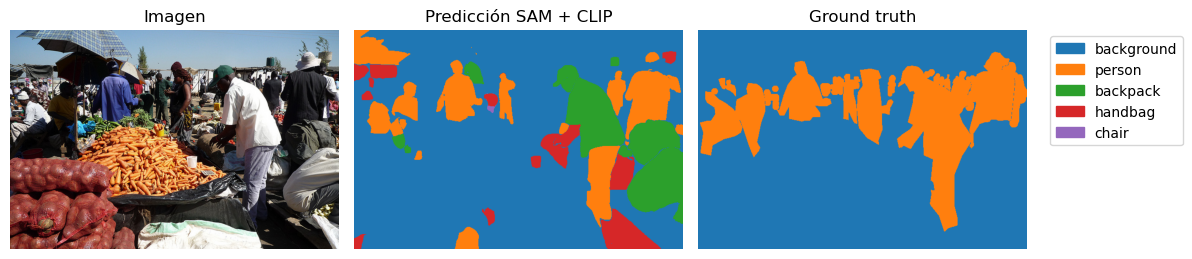

In [24]:
plot_image_and_mask_and_gt(img, result_mask , mask)

In [36]:
def process_inference_sam_clip(image, clip_model, sam_model):

    result_sam = sam_model.generate(image)
    result = np.zeros((image.shape[0], image.shape[1]))


    for i, mask_dict in enumerate(result_sam):
        mask = mask_dict["segmentation"]  
        clip_input, cropped_pil = prepare_clip_input_from_mask(image, mask, preprocess)

        if clip_input is None:
            continue

        # Encode image and text
        with torch.no_grad():
            image_features = clip_model.encode_image(clip_input)
            text_features = clip_model.encode_text(text_tokens)

            # Normalize
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)

            # Cosine similarity
            similarity = (image_features @ text_features.T).squeeze(0)
            best_idx = similarity.argmax().item()

            if(best_idx<10):
                result[mask] = best_idx + 1

    return result

In [37]:
result = process_inference_sam_clip(img, clip_model, mask_generator)

In [38]:
proprocessed_mask = preprocess_model_output(result)

## 2. Obtención de métricas de rendimiento

A continuación, se procede con la obtención de las métricas de rendimiento recogidas para el resto de los modelos para su posterior análisis y comparativa

In [39]:
CONS_OUTPUT_PATH = r"src\logs\train\results.csv"

In [40]:

def compute_iou(pred_mask, true_mask) -> float:


    ious = []
    num_classes = pred_mask.shape[0]

    for c in range(num_classes):
        pred = pred_mask[c]
        truth = true_mask[c]

        if  truth.any():

            intersection = np.logical_and(pred, truth).sum()
            union = np.logical_or(pred, truth).sum()

            iou = intersection / union if union != 0 else 0.0
            ious.append(iou)

            # print("For class ", c, " has value ", iou)



    return np.mean(ious)


In [41]:

def mean_pixel_accuracy(pred_mask, true_mask) -> float:


    class_accuracies = []

    for c in range(pred_mask.shape[0]):
        pred = pred_mask[c]
        truth = true_mask[c]

        total_true = truth.sum()
        if total_true != 0:

            correct = np.logical_and(pred, truth).sum()
            acc = correct / total_true
            class_accuracies.append(acc)
            
            # print("For class ", c, " has value ", acc)

    return np.mean(class_accuracies)



In [42]:


def mean_average_precision(prob_mask, true_mask) -> float:

    C, H, W = true_mask.shape
    aps = []

    for c in range(C):
        y_true = true_mask[c].ravel().astype(int)
        y_score = prob_mask[c].ravel()

        if y_true.sum() != 0:
            ap = average_precision_score(y_true, y_score)
            aps.append(ap)

            # print("for ", c, " has value ",ap)


    return np.mean(aps)



In [43]:
def get_value_metrics(prob_mask, ground_truth) -> tuple[float, float, float ]:

    # result = mean_pixel_accuracy(mask_one_hot_pred, mask_one_hot_gt)
    mean_pixel_acc = mean_pixel_accuracy(prob_mask, ground_truth)

    # result = compute_iou(mask_one_hot_pred, mask_one_hot_gt)

    iou = compute_iou(prob_mask, ground_truth)

    # mean_average_precision(one_hot_scores[0],mask_one_hot_gt )
    mean_av_pre = mean_average_precision(prob_mask, ground_truth)
    
    return mean_pixel_acc, iou, mean_av_pre



In [44]:
N = 40

0it [00:00, ?it/s]

we have shape (11, 427, 640)
our output has shape (11, 427, 640)


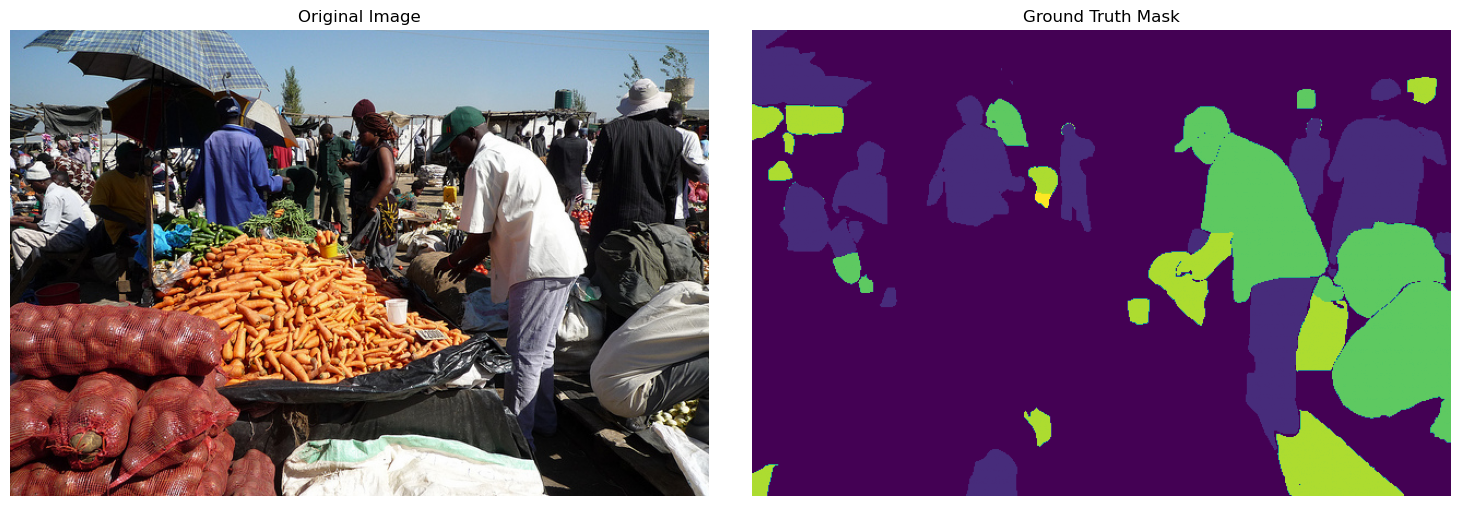

1it [05:17, 317.99s/it]

metrics are  0.6359238537415158 0.5772197335160121 0.6835319617305642
we have shape (11, 640, 480)
our output has shape (11, 640, 480)


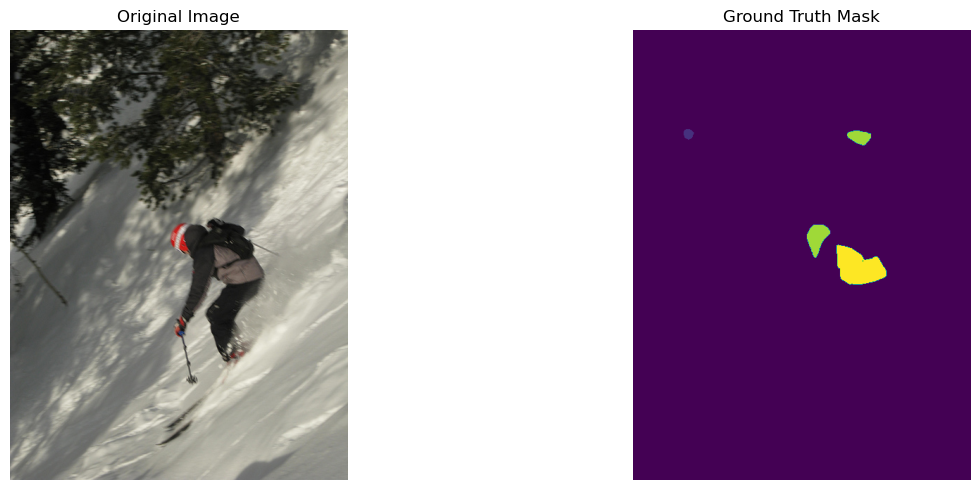

2it [08:22, 239.71s/it]

metrics are  0.3325544227695752 0.31640163542064653 0.3369928141439588
we have shape (11, 426, 640)
our output has shape (11, 426, 640)


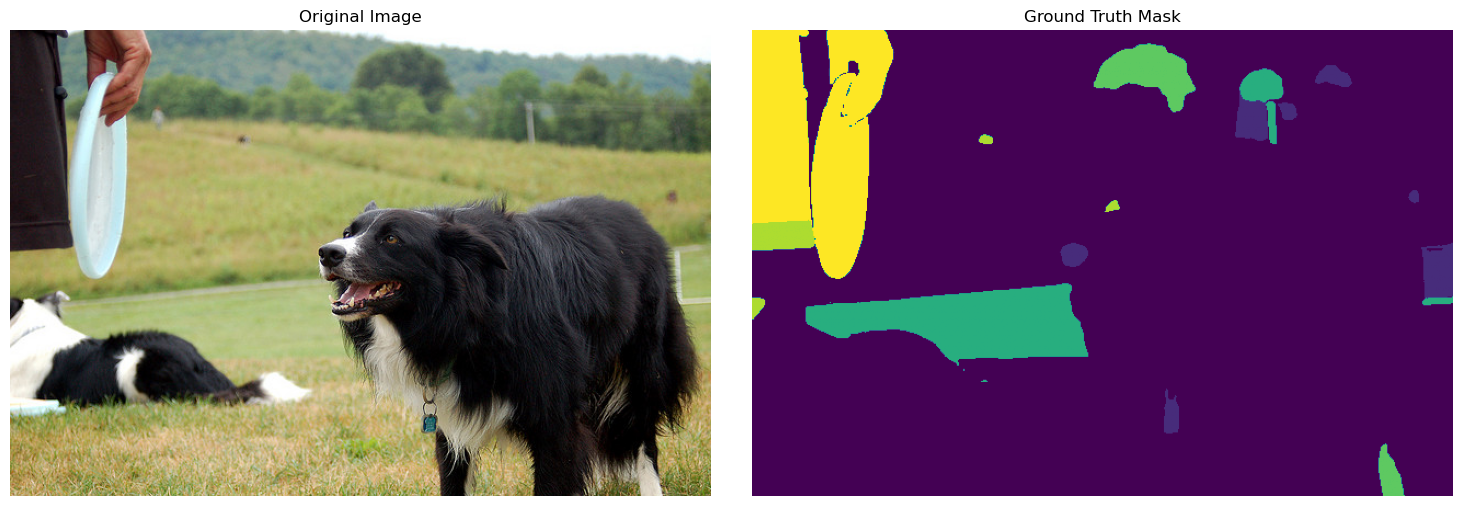

3it [12:02, 230.70s/it]

metrics are  0.4469744670770082 0.444489387511224 0.5217855243259231
we have shape (11, 512, 640)
our output has shape (11, 512, 640)


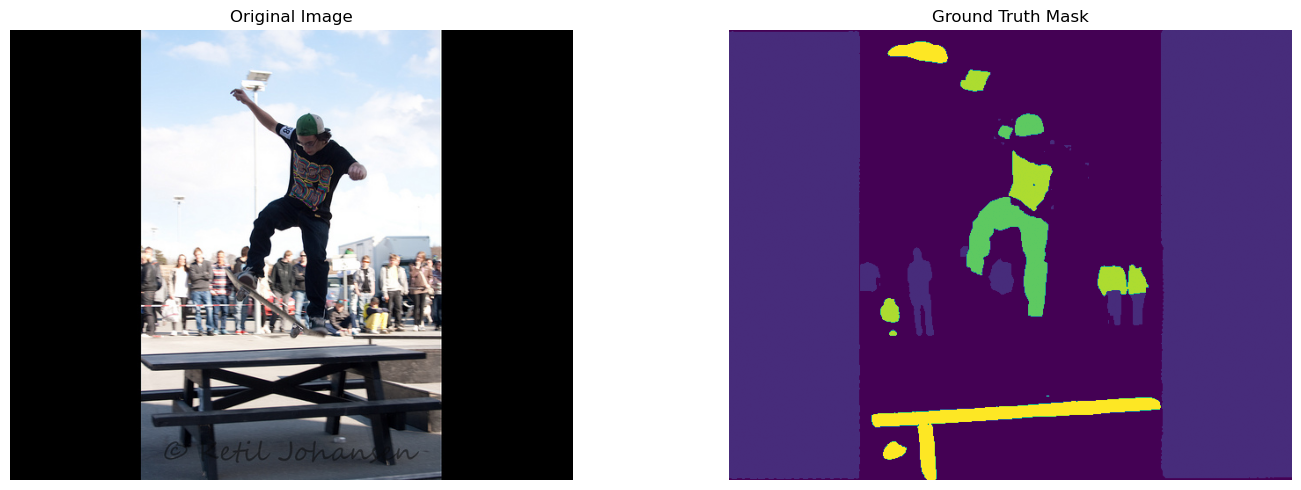

4it [15:50, 229.39s/it]

metrics are  0.29062182879466064 0.10615360631267852 0.21067612360877877
we have shape (11, 446, 640)
our output has shape (11, 446, 640)


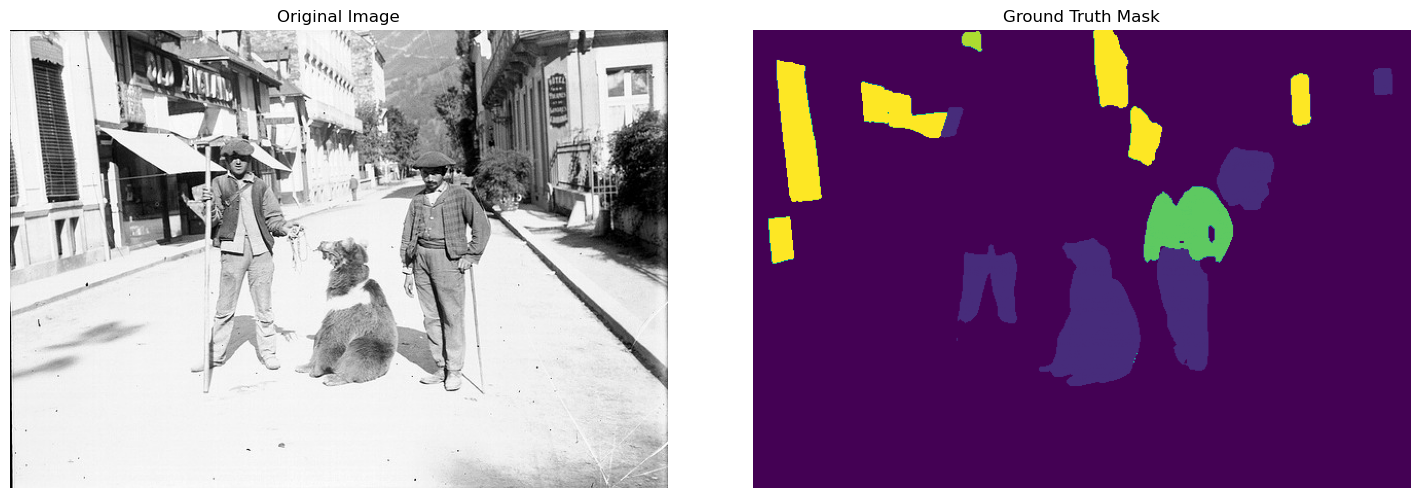

5it [19:45, 231.58s/it]

metrics are  0.6127713378419037 0.5384545946995368 0.5609745494910273
we have shape (11, 428, 640)


5it [21:32, 258.47s/it]


KeyboardInterrupt: 

In [46]:


list_mean_pixel_acc = []
list_iou = []
list_mean_av_prec = []
list_inference_time = []

ids_under_threshold = []
ids_over_threshold = []


for i, img_id in tqdm(enumerate(img_ids[:N])):
    try:


        image, mask_gt = get_data_id_image(img_id, coco)
        mask_preprocessed_gt = preprocess_dataset_mask(mask_gt,mapper_indexModel_index_result, categories_names_by_index)
        print("we have shape", mask_preprocessed_gt.shape)

        comienzo_inferencia = time.time()
        result = process_inference_sam_clip(image, clip_model, mask_generator)
        proprocessed_mask = preprocess_model_output(result)
        print("our output has shape",proprocessed_mask.shape )


        plt.figure(figsize=(15, 5))

        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.imshow(image)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title("Ground Truth Mask")
        plt.imshow(result)
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        fin_inferencia = time.time()

        mean_pixel_acc, iou, mean_av_pre = get_value_metrics(proprocessed_mask, mask_preprocessed_gt) 
        print("metrics are ", mean_pixel_acc, iou, mean_av_pre)


        list_mean_pixel_acc.append(mean_pixel_acc)
        list_iou.append(iou)
        list_mean_av_prec.append(mean_av_pre)
        list_inference_time.append(round(fin_inferencia -comienzo_inferencia, 2) )

        if(mean_pixel_acc> 0.95):
            ids_over_threshold.append(img_id)

        elif(iou<0.5):
            ids_under_threshold.append(img_id)
            
    except Exception as e:
        print("Error in iteration ",  i, ": ", e)



In [ ]:


try:
    df = pd.read_csv(CONS_OUTPUT_PATH)
except Exception as e:
    df = pd.DataFrame()


results = pd.DataFrame({
    "Model":["Ensable_RetinaNet+SAM"],
    "Mean_Pixel_Accuracy":[sum(list_mean_pixel_acc)/ len(list_mean_pixel_acc)],
    "Intersection_Over_Union":[sum(list_iou)/len(list_iou)],
    "Mean_Average_Precission":[sum(list_mean_av_prec)/len(list_mean_av_prec)],
    "Inference_Time":[sum(list_inference_time)/len(list_inference_time)]



})

df = pd.concat([df, results], ignore_index=True)


df.to_csv(CONS_OUTPUT_PATH, index=False)
